# Data Exploration and Preprocessing

Author: [DURUII](https://github.com/DURUII?tab=repositories)

Ref:
1. 《交通时空大数据：分析、挖掘与可视化》
2. https://contextily.readthedocs.io/en/latest/providers_deepdive.html
3. https://geopandas.org/en/stable/getting_started/introduction.html#Buffer

In [1]:
import pandas as pd
import os
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np

import scienceplots

plt.style.use(['science', 'grid'])

# dataset link: https://ieee-dataport.org/open-access/crawdad-romataxi
if not os.path.exists('./dataset/taxi_february.pkl'):
    df = pd.read_csv('./dataset/taxi_february.txt',
                     sep=';', header=None,
                     names=['DRIVER_ID', 'TIMESTAMP', 'POSITION'])

    df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x: parser.parse(x))

    df[['LATITUDE', 'LONGITUDE']] = df['POSITION'].str.extract(
        r'POINT\(([^ ]+) ([^ ]+)\)')
    df['LATITUDE'] = df['LATITUDE'].astype(float)
    df['LONGITUDE'] = df['LONGITUDE'].astype(float)
    df = df.drop('POSITION', axis=1)

    df.to_pickle('./dataset/taxi_february.pkl')

df = pd.read_pickle('./dataset/taxi_february.pkl')
df

DRIVER_ID                        TIMESTAMP   LATITUDE  LONGITUDE
0               156 2014-02-01 00:00:00.739166+01:00  41.883672  12.487778
1               187 2014-02-01 00:00:01.148457+01:00  41.928543  12.469037
2               297 2014-02-01 00:00:01.220066+01:00  41.891069  12.492705
3                89 2014-02-01 00:00:01.470854+01:00  41.793177  12.432122
4                79 2014-02-01 00:00:01.631136+01:00  41.900275  12.462746
...             ...                              ...        ...        ...
21817846        220 2014-03-02 23:59:58.282599+01:00  41.901199  12.484496
21817847        324 2014-03-02 23:59:58.460481+01:00  41.897262  12.472831
21817848        266 2014-03-02 23:59:58.468372+01:00  41.909772  12.529965
21817849        360 2014-03-02 23:59:58.886768+01:00  41.912769  12.417502
21817850        113 2014-03-02 23:59:58.943143+01:00  41.880361  12.508293

[21817851 rows x 4 columns]

## Basic Info

In [2]:
df['TIMESTAMP'].dt.date.nunique()

30

In [3]:
df['DRIVER_ID'].nunique(), df['DRIVER_ID'].unique()

(316,
 array([156, 187, 297,  89,  79, 191, 343, 341, 260,  59, 122, 311, 351,
         58, 196, 105, 331, 362, 188, 172, 352, 361, 321, 318, 317, 368,
        295, 197, 298, 232, 315,   2, 135, 248, 132, 104, 234, 357, 281,
         53, 257,  37, 224, 178, 174,  61, 291, 365,  94, 228, 259, 193,
         80, 137,  24, 124, 162,  71,  46, 127, 155,  70, 359, 290,  11,
        149,  72, 254, 353,  45,  51, 153, 275, 101, 310, 256,  50,  67,
        112, 160,  95,  12,  83,  68,  84, 109, 336, 229, 202, 211, 103,
        102,  47, 335, 326, 128, 363,  31, 140,  19, 121, 269, 309,  93,
        163, 214,  43, 293, 305, 322, 179, 274,   8, 134,  13, 150, 255,
        264, 252, 213, 348, 159,  96,  91, 289, 243,  74, 306, 366,  65,
        329, 185,  14,  78,  66, 249, 180, 280,  99, 350, 316, 334, 167,
        157, 120, 190, 282, 288, 342, 283, 360,  92, 250, 268, 330, 355,
        192, 170,   7, 273, 175, 235,  73, 344, 346, 266, 169, 223,  21,
          3,  85, 324, 337, 198,  81,  87, 11

## Hourly Data Volumn

In [4]:
data = df[df.TIMESTAMP.dt.date == df.TIMESTAMP.dt.date.min()]
count_hour = data.groupby(data.TIMESTAMP.dt.hour).size()
count_hour

TIMESTAMP
0     11721
1      8576
2      6017
3      3709
4      3061
5      5715
6      8960
7     10286
8     12029
9     12921
10    13246
11    12830
12    12223
13    14239
14    13964
15    11832
16    14900
17    16119
18    16378
19    16804
20    17569
21    17472
22    17736
23    14988
dtype: int64

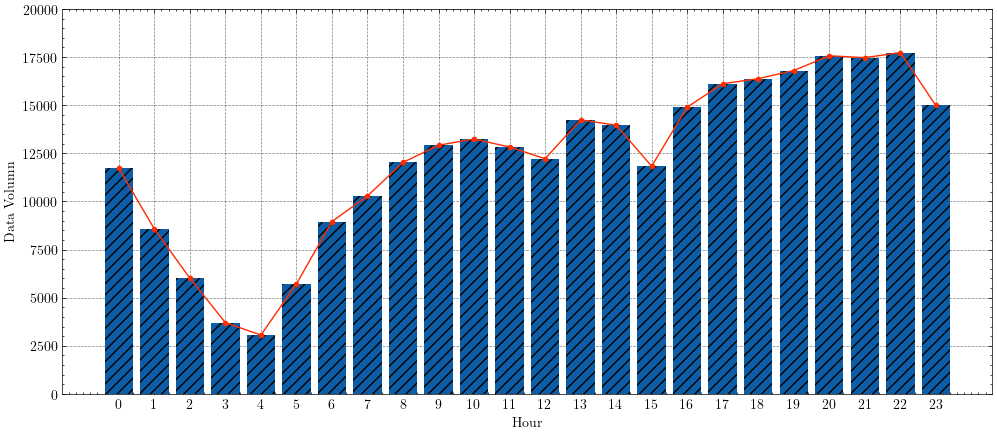

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=count_hour.index, height=count_hour.values, hatch='///')
ax.plot(count_hour.index, count_hour.values, color='C3', marker='.')
ax.set_xlabel('Hour')
ax.set_ylabel('Data Volumn')
ax.set_xticks(range(24), range(24))
ax.set_ylim(0, 20000)
plt.show()

## Map

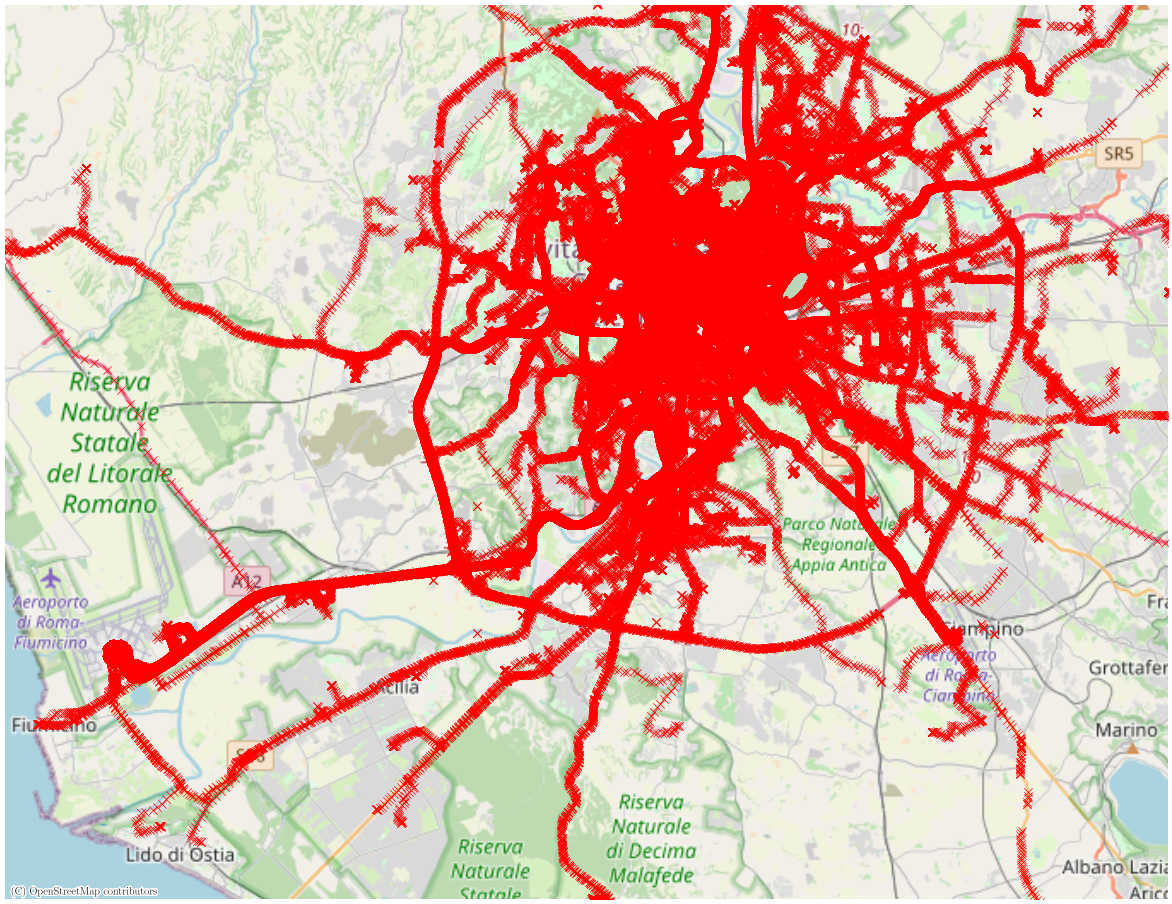

In [23]:
import random
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# choose one specific day
date = random.choice(df['TIMESTAMP'].dt.date.unique())
data = df[df['TIMESTAMP'].dt.date == date]
# outlier removal
data = data[(data['LONGITUDE'] < 15) & (data['LATITUDE'] < 44)]
# create data frame with geometry
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(
    data['LONGITUDE'], data['LATITUDE']), crs='EPSG:4326').to_crs(epsg=3857)
gdf = gdf.drop(['LONGITUDE', 'LATITUDE'], axis=1)
# plot it
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x=gdf.geometry.x.values, y=gdf.geometry.y.values,
           c='red', marker='x', linewidths=0.5)
ax.set_xlim(1.359e6, 1.411e6)
ax.set_ylim(5.119e6, 5.159e6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.savefig(f'./dataset/{date}.trace.png')
gdf.to_file(f'./dataset/{date}.geojson')


## Simulation Settings

### First, select locations from the trace as the task locations

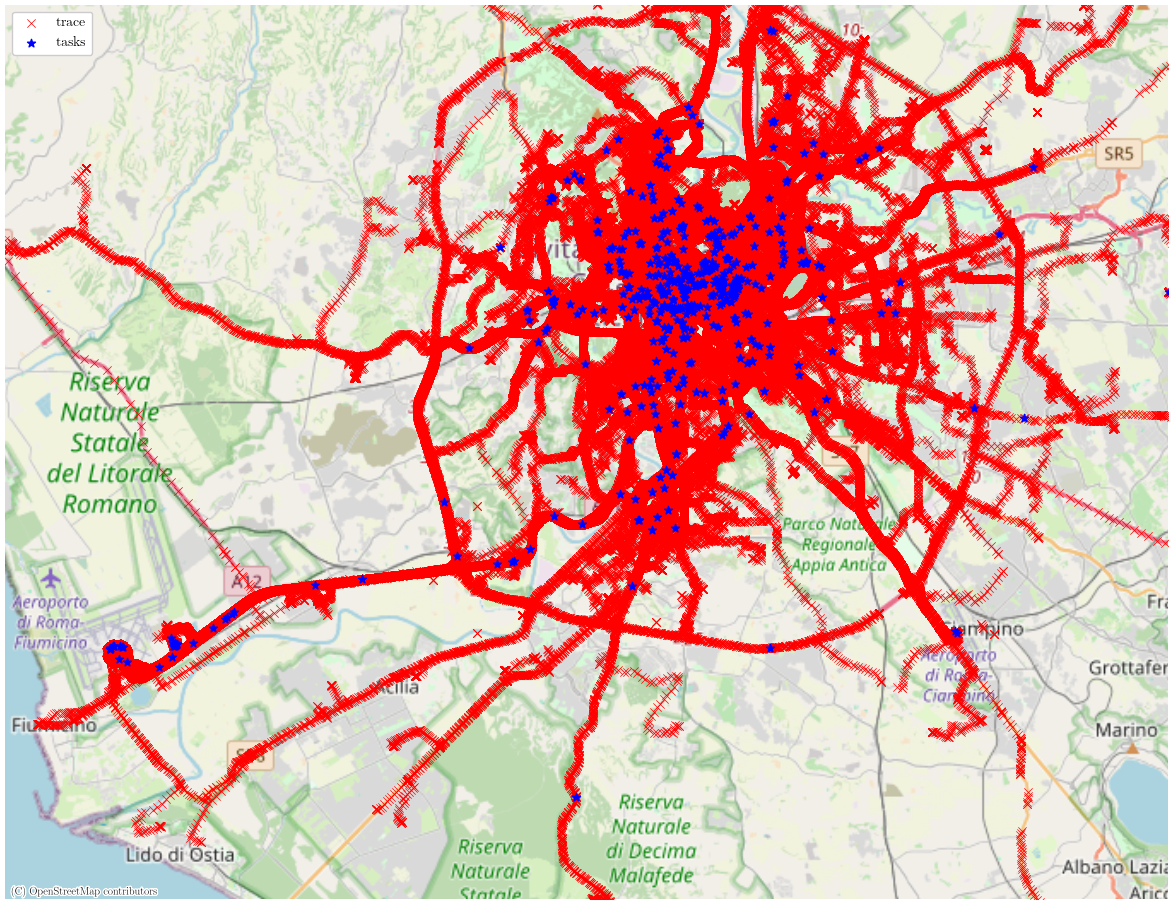

In [80]:
gdf = gpd.read_file(f'./dataset/{date}.geojson')
tasks = gdf.sample(n=600, random_state=5)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x=gdf.geometry.x.values, y=gdf.geometry.y.values,
           c='red', marker='x', linewidths=0.5, label='trace')
ax.scatter(x=tasks.geometry.x.values, y=tasks.geometry.y.values,
           c='blue', marker='*', linewidths=1, label='tasks')
ax.set_xlim(1.359e6, 1.411e6)
ax.set_ylim(5.119e6, 5.159e6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.legend()
plt.savefig(f'./dataset/{date}.tasks.png')


### Then, we use a geographic region with radius 200m

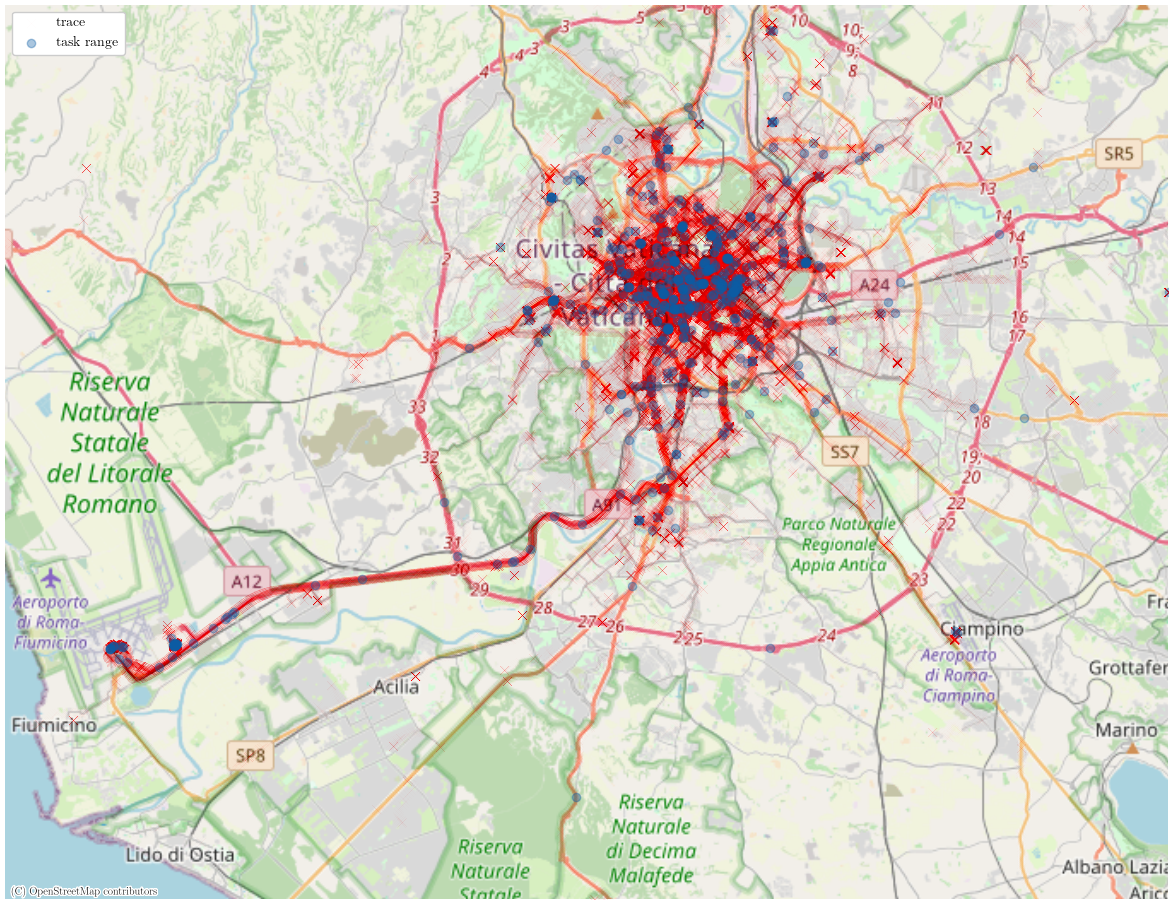

In [61]:
tasks['buffer'] = tasks.geometry.buffer(200)
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(x=gdf.geometry.x.values, y=gdf.geometry.y.values,
           c='red', marker='x', linewidths=0.1, label='trace', alpha=0.05)
# ax.scatter(x=tasks.geometry.x.values, y=tasks.geometry.y.values,
#            c='blue', marker='*', linewidths=1, label='tasks', alpha=0.1)
tasks.plot(ax=ax, alpha=0.35, label='task range')

ax.set_xlim(1.359e6, 1.411e6)
ax.set_ylim(5.119e6, 5.159e6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.legend()
plt.savefig(f'./dataset/{date}.range.png')


In [62]:
gdf_full = gpd.GeoDataFrame(df.drop(['LONGITUDE', 'LATITUDE'], axis=1),
                            geometry=gpd.points_from_xy(
    df['LONGITUDE'], df['LATITUDE']), crs='EPSG:4326').to_crs(epsg=3857)

In [72]:
tasks_active = tasks.set_geometry('buffer')
tasks_active.drop(['DRIVER_ID', 'TIMESTAMP'], axis=1, inplace=True)
tasks_active

geometry  \
548419  POINT (1387479.473 5150424.343)   
493749  POINT (1388819.083 5137961.366)   
459425  POINT (1384799.311 5135766.102)   
564898  POINT (1390836.664 5148291.750)   
314011  POINT (1386446.276 5147579.457)   
...                                 ...   
368920  POINT (1385752.474 5145337.849)   
636379  POINT (1387378.125 5148357.677)   
731181  POINT (1391229.575 5147667.886)   
791897  POINT (1385954.748 5147345.601)   
541159  POINT (1392327.349 5149530.621)   

                                                   buffer  
548419  POLYGON ((1387679.473 5150424.343, 1387678.510...  
493749  POLYGON ((1389019.083 5137961.366, 1389018.120...  
459425  POLYGON ((1384999.311 5135766.102, 1384998.347...  
564898  POLYGON ((1391036.664 5148291.750, 1391035.701...  
314011  POLYGON ((1386646.276 5147579.457, 1386645.312...  
...                                                   ...  
368920  POLYGON ((1385952.474 5145337.849, 1385951.511...  
636379  POLYGON ((1387578.125 5148357.677, 1387577.162...  
731181  POLYGON ((1391429.575 5147667.886, 1391428.612...  
791897  POLYGON ((1386154.748 5147345.601, 1386153.785...  
541159  POLYGON ((1392527.349 5149530.621, 1392526.386...  

[600 rows x 2 columns]

### we use the frequency value to denote the expected mean $q_i$

In [113]:
within_tasks_buffer = gpd.sjoin(gdf, tasks_active, how='inner', predicate='within')
within_tasks_buffer
driver_counts_within = within_tasks_buffer['DRIVER_ID'].value_counts().reset_index()
driver_counts_within.columns = ['DRIVER_ID', 'WITHIN']
driver_counts_within.to_csv('./dataset/workers.csv')
driver_counts_within

DRIVER_ID  WITHIN
0           42   54236
1          224   53511
2          308   53365
3          370   50655
4          329   47860
..         ...     ...
279        119     543
280         54     374
281        312     278
282        123     259
283        313     152

[284 rows x 2 columns]

In [114]:
workers = gdf[gdf['DRIVER_ID'].isin(driver_counts_within['DRIVER_ID'])]
workers

DRIVER_ID                         TIMESTAMP  \
0             311  2014-02-14T00:00:00.035000+01:00   
1             232  2014-02-14T00:00:00.163000+01:00   
2             127  2014-02-14T00:00:00.763000+01:00   
3             357  2014-02-14T00:00:01.038000+01:00   
4             297  2014-02-14T00:00:01.436000+01:00   
...           ...                               ...   
890172        365  2014-02-14T23:59:59.127998+01:00   
890173        344  2014-02-14T23:59:59.230999+01:00   
890174        295  2014-02-14T23:59:59.279999+01:00   
890175        155  2014-02-14T23:59:59.868999+01:00   
890176        127  2014-02-14T23:59:59.976002+01:00   

                               geometry  
0       POINT (1388892.108 5145413.369)  
1       POINT (1389405.814 5145180.046)  
2       POINT (1390453.003 5138322.073)  
3       POINT (1391485.217 5148712.610)  
4       POINT (1388112.730 5144868.202)  
...                                 ...  
890172  POINT (1389240.106 5147613.623)  
890173  POINT (1389345.832 5146721.975)  
890174  POINT (1390035.186 5145893.426)  
890175  POINT (1388459.719 5146365.967)  
890176  POINT (1387974.862 5145019.648)  

[890177 rows x 3 columns]

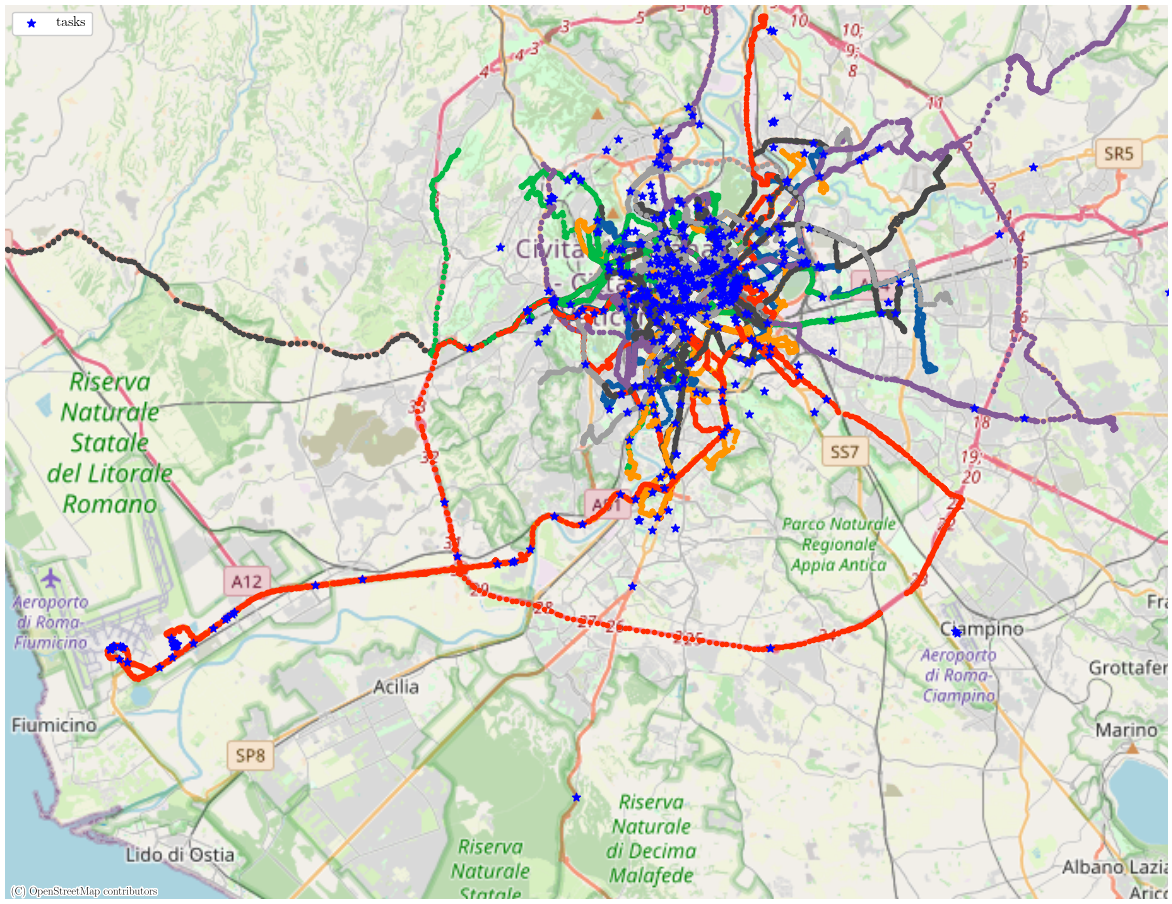

In [98]:
fig, ax = plt.subplots(figsize=(15, 15))

for w_id in workers['DRIVER_ID'].unique()[:14]:
    trace = workers[workers['DRIVER_ID'] == w_id]
    ax.scatter(x=trace.geometry.x.values, y=trace.geometry.y.values,
            marker='.')

ax.scatter(x=tasks.geometry.x.values, y=tasks.geometry.y.values,
           c='blue', marker='*', linewidths=1, label='tasks')

ax.set_xlim(1.359e6, 1.411e6)
ax.set_ylim(5.119e6, 5.159e6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.legend()
plt.savefig(f'./dataset/{date}.workers.png')

In [112]:
workers.to_file('./dataset/workers.gpkg')
workers

DRIVER_ID                         TIMESTAMP  \
0             311  2014-02-14T00:00:00.035000+01:00   
1             232  2014-02-14T00:00:00.163000+01:00   
2             127  2014-02-14T00:00:00.763000+01:00   
3             357  2014-02-14T00:00:01.038000+01:00   
4             297  2014-02-14T00:00:01.436000+01:00   
...           ...                               ...   
890172        365  2014-02-14T23:59:59.127998+01:00   
890173        344  2014-02-14T23:59:59.230999+01:00   
890174        295  2014-02-14T23:59:59.279999+01:00   
890175        155  2014-02-14T23:59:59.868999+01:00   
890176        127  2014-02-14T23:59:59.976002+01:00   

                               geometry  
0       POINT (1388892.108 5145413.369)  
1       POINT (1389405.814 5145180.046)  
2       POINT (1390453.003 5138322.073)  
3       POINT (1391485.217 5148712.610)  
4       POINT (1388112.730 5144868.202)  
...                                 ...  
890172  POINT (1389240.106 5147613.623)  
890173  POINT (1389345.832 5146721.975)  
890174  POINT (1390035.186 5145893.426)  
890175  POINT (1388459.719 5146365.967)  
890176  POINT (1387974.862 5145019.648)  

[890177 rows x 3 columns]

In [109]:
tasks.drop(['buffer'], axis=1).to_file('./dataset/tasks.geojson')
tasks

DRIVER_ID                         TIMESTAMP  \
548419        326  2014-02-14T17:15:52.306999+01:00   
493749        112  2014-02-14T16:22:23.610001+01:00   
459425        366  2014-02-14T15:42:41.108002+01:00   
564898        269  2014-02-14T17:31:47.139999+01:00   
314011        340  2014-02-14T13:05:03.516000+01:00   
...           ...                               ...   
368920         28  2014-02-14T14:01:09.383000+01:00   
636379        275  2014-02-14T18:40:57.686001+01:00   
731181        132  2014-02-14T20:14:22.209999+01:00   
791897        269  2014-02-14T21:17:14.821000+01:00   
541159        309  2014-02-14T17:09:04.803000+01:00   

                               geometry  \
548419  POINT (1387479.473 5150424.343)   
493749  POINT (1388819.083 5137961.366)   
459425  POINT (1384799.311 5135766.102)   
564898  POINT (1390836.664 5148291.750)   
314011  POINT (1386446.276 5147579.457)   
...                                 ...   
368920  POINT (1385752.474 5145337.849)   
636379  POINT (1387378.125 5148357.677)   
731181  POINT (1391229.575 5147667.886)   
791897  POINT (1385954.748 5147345.601)   
541159  POINT (1392327.349 5149530.621)   

                                                   buffer  
548419  POLYGON ((1387679.473 5150424.343, 1387678.510...  
493749  POLYGON ((1389019.083 5137961.366, 1389018.120...  
459425  POLYGON ((1384999.311 5135766.102, 1384998.347...  
564898  POLYGON ((1391036.664 5148291.750, 1391035.701...  
314011  POLYGON ((1386646.276 5147579.457, 1386645.312...  
...                                                   ...  
368920  POLYGON ((1385952.474 5145337.849, 1385951.511...  
636379  POLYGON ((1387578.125 5148357.677, 1387577.162...  
731181  POLYGON ((1391429.575 5147667.886, 1391428.612...  
791897  POLYGON ((1386154.748 5147345.601, 1386153.785...  
541159  POLYGON ((1392527.349 5149530.621, 1392526.386...  

[600 rows x 4 columns]